# GOALS FOR TOMORROW:

* Euclidean + Jaccard Graphs
* Build a crappy model

In [1]:
## testing printing output from console
import subprocess
cmd = [ 'echo', '"Welcome to my PySpark analysis of some StackOverflow Data"' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

b'"Welcome to my PySpark analysis of some StackOverflow Data"\n'


In [2]:
## import standard libraries
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

#%matplotlib inline

In [3]:
# import spark with SparkSession - WORKS!

import findspark # needed on local computer
findspark.init()

import pyspark

spark = (
    pyspark.sql.SparkSession
    .builder
    .master("local[4]") # we can use [X] to limit the number of cores spark uses
    #.config("spark.jars.packages", "com.databricks:spark-xml_2.11:0.4.1")
    .getOrCreate()
)
spark

In [4]:
## check default number of partitions - WORKS!
spark.sparkContext.defaultParallelism

4

# Data read-in

In [5]:
%%time

## array of dataset names to loop through in analysis
data_array = [
    "english",
    "math",
    "rus_stackoverflow",
    "stackoverflow",
    "superuser"
]

datasets = {}    

## read in parquet files which are all named file-01.parquet
for i in data_array:
    datasets[i] = (
        spark
        .read
        .load("initial-data/" + i + ".stackexchange.com/file-01.parquet")
)

CPU times: user 2.87 ms, sys: 3.45 ms, total: 6.33 ms
Wall time: 4.07 s


In [6]:
for i in data_array:
    print("------------------------")
    print(i)
    print("------------------------")
    datasets[i].printSchema()
    datasets[i].show(3)

------------------------
english
------------------------
root
 |-- _Body: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)
 |-- _Score: long (nullable = true)

+--------------------+--------------------+----------+------+
|               _Body|              _Title|_ViewCount|_Score|
+--------------------+--------------------+----------+------+
|<p>How do I know ...|What is the diffe...|     18413|    35|
|<p>When you want ...|Should I use a se...|    106724|    52|
|<blockquote>
  <p...|What does Maugham...|      1131|    11|
+--------------------+--------------------+----------+------+
only showing top 3 rows

------------------------
math
------------------------
root
 |-- Body: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- __index_level_0__: long (nullable = true)

+--------------------+--------------------+---------+-----+--------

In [7]:
def show(df, n=5):
    '''
    function to better print spark df entries
    '''
    display(pd.DataFrame(df.head(n), columns=df.columns))

In [8]:
show(datasets["english"])

,_Body,_Title,_ViewCount,_Score
0,<p>How do I know when to use <em>lay</em> and ...,"What is the difference between ""lay"" and ""lie""?",18413,35
1,<p>When you want to connect two closely relate...,Should I use a semicolon or a dash to connect ...,106724,52
2,<blockquote>\n <p><strong>Possible Duplicate:...,"What does Maugham mean by ""his spaghetti were""?",1131,11
3,<p>How do you say it correctly?</p>\n\n<ul>\n<...,"""Adult and children stories"" or ""Adults and ch...",959,2
4,"<p>""Proven"" and ""proved"" both seem to mean the...","What is the difference between ""proven"" and ""p...",52711,50


# Cleaning

In [9]:
## dropping index columns
for i in datasets:
    datasets[i] = datasets[i].drop('__index_level_0__')

In [10]:
from functools import reduce

In [11]:
## sanitising column names

for i in data_array:
    oldColumns = datasets[i].schema.names
    newColumns = ["body", "title", "viewcount", "score"]
    datasets[i] = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), datasets[i])

In [12]:
## changing numeric columns to long type

for i in data_array:
    for j in ['viewcount', 'score']:
        datasets[i] = datasets[i].withColumn(j, datasets[i][j].cast("long"))

In [13]:
%%time

from pyspark.sql.types import *
from pyspark.sql.functions import udf

## create regex user-defined function to clean body column

def clean_body(a):
    '''regex function to clean html tags from body content'''
    x = re.sub("\n|<.*?>", " ", a)
    return x

clean_body_udf = udf(clean_body, StringType())

## create clean_body column for all datasets

for i in data_array:
    datasets[i] = datasets[i].withColumn("clean_body", clean_body_udf('body'))

CPU times: user 23 ms, sys: 3.92 ms, total: 26.9 ms
Wall time: 126 ms


In [14]:
## check columns are the right types and names
for i in data_array:
    print("----- " + i + " -----")
    print(datasets[i].printSchema())

----- english -----
root
 |-- body: string (nullable = true)
 |-- title: string (nullable = true)
 |-- viewcount: long (nullable = true)
 |-- score: long (nullable = true)
 |-- clean_body: string (nullable = true)

None
----- math -----
root
 |-- body: string (nullable = true)
 |-- title: string (nullable = true)
 |-- viewcount: long (nullable = true)
 |-- score: long (nullable = true)
 |-- clean_body: string (nullable = true)

None
----- rus_stackoverflow -----
root
 |-- body: string (nullable = true)
 |-- title: string (nullable = true)
 |-- viewcount: long (nullable = true)
 |-- score: long (nullable = true)
 |-- clean_body: string (nullable = true)

None
----- stackoverflow -----
root
 |-- body: string (nullable = true)
 |-- title: string (nullable = true)
 |-- viewcount: long (nullable = true)
 |-- score: long (nullable = true)
 |-- clean_body: string (nullable = true)

None
----- superuser -----
root
 |-- body: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vi

In [15]:
%%time

## double check that there are no nans

from pyspark.sql.functions import isnan, when, count, col, lit

for i in data_array:
    print("----- " + i + " -----")
    datasets[i].select([count(when(isnan(c), c)).alias(c) for c in datasets[i].columns]).show()

----- english -----
+----+-----+---------+-----+----------+
|body|title|viewcount|score|clean_body|
+----+-----+---------+-----+----------+
|   0|    0|        0|    0|         0|
+----+-----+---------+-----+----------+

----- math -----
+----+-----+---------+-----+----------+
|body|title|viewcount|score|clean_body|
+----+-----+---------+-----+----------+
|   0|    0|        0|    0|         0|
+----+-----+---------+-----+----------+

----- rus_stackoverflow -----
+----+-----+---------+-----+----------+
|body|title|viewcount|score|clean_body|
+----+-----+---------+-----+----------+
|   0|    0|        0|    0|         0|
+----+-----+---------+-----+----------+

----- stackoverflow -----
+----+-----+---------+-----+----------+
|body|title|viewcount|score|clean_body|
+----+-----+---------+-----+----------+
|   0|    0|        0|    0|         0|
+----+-----+---------+-----+----------+

----- superuser -----
+----+-----+---------+-----+----------+
|body|title|viewcount|score|clean_body|
+


# EDA

In [16]:
## find average views
for i in datasets:
    print("----- " + i + " -----")
    datasets[i].select("viewcount").describe().show() # have to use select here

----- english -----
+-------+-----------------+
|summary|        viewcount|
+-------+-----------------+
|  count|           105475|
|   mean|7417.237648731927|
| stddev|31784.76798660533|
|    min|                3|
|    max|          1827972|
+-------+-----------------+

----- math -----
+-------+------------------+
|summary|         viewcount|
+-------+------------------+
|  count|           1063074|
|   mean|  544.894225613645|
| stddev|3511.9471122530717|
|    min|                 1|
|    max|            686949|
+-------+------------------+

----- rus_stackoverflow -----
+-------+----------------+
|summary|       viewcount|
+-------+----------------+
|  count|          256042|
|   mean|563.832793057389|
| stddev|2462.60572266293|
|    min|               1|
|    max|          209859|
+-------+----------------+

----- stackoverflow -----
+-------+------------------+
|summary|         viewcount|
+-------+------------------+
|  count|            355203|
|   mean|  2290.24475863098|
| s

In [17]:
## highest viewed questions across fora

for i in data_array:
    print("----- " + i + " -----")
    print(datasets[i].where(
        datasets[i].viewcount == datasets[i].select('viewcount').
        rdd.flatMap(lambda x: x).max()).collect())

----- english -----
[Row(body="<p>I'm wondering what is the <em>best</em> way to express that an email contains an attachment. I'd like to have a formal example, and an informal example.</p>\n\n<p>For example:</p>\n\n<p>Is this informal?</p>\n\n<blockquote>\n  <p>Attached you can find the document... </p>\n</blockquote>\n\n<p>Is this too formal? too old school?</p>\n\n<blockquote>\n  <p>Please find enclosed the document...</p>\n</blockquote>\n", title='What is the *best* way to express that an email contains an attachment?', viewcount=1827972, score=9, clean_body=" I'm wondering what is the  best  way to express that an email contains an attachment. I'd like to have a formal example, and an informal example.    For example:    Is this informal?        Attached you can find the document...       Is this too formal? too old school?        Please find enclosed the document...    ")]
----- math -----
[Row(body='<p>This is one of those popular pictures on sites like Facebook. I always see a

In [18]:
import seaborn as sns

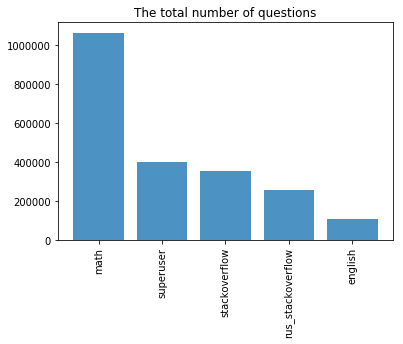

CPU times: user 128 ms, sys: 12.4 ms, total: 141 ms
Wall time: 802 ms


In [19]:
%%time

## total number of questions across fora

## empty dictionary of df skeleton
plot_data = {}

## collect data
for i in data_array:
    plot_data[i] = datasets[i].count()
    
## bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('The total number of questions')
plt.show()

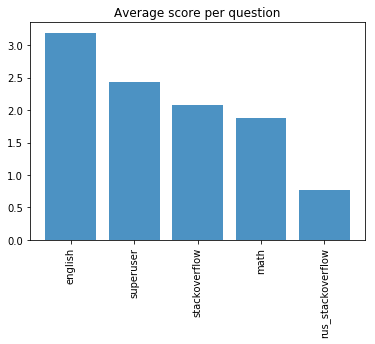

CPU times: user 158 ms, sys: 13.8 ms, total: 171 ms
Wall time: 957 ms


In [20]:
%%time

## average score per post across fora

## empty dictionary of df skeleton
plot_data = {}


## collect data
for i in data_array:
    plot_data[i] = datasets[i].groupBy().avg('score').collect()[0][0]
    
## bar plot of score per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average score per question')
plt.show()

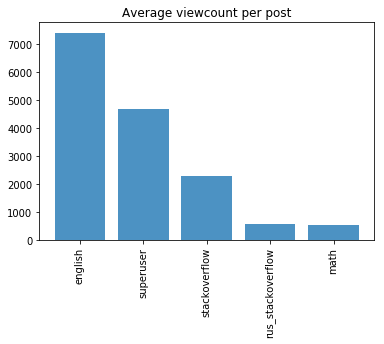

CPU times: user 129 ms, sys: 11.2 ms, total: 140 ms
Wall time: 840 ms


In [21]:
%%time

## average score per post across fora

## empty dictionary of df skeleton
plot_data = {}

## collect data
for i in data_array:
    plot_data[i] = datasets[i].groupBy().avg('viewcount').collect()[0][0]
    
## bar plot of viewcount per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average viewcount per post')
plt.show()

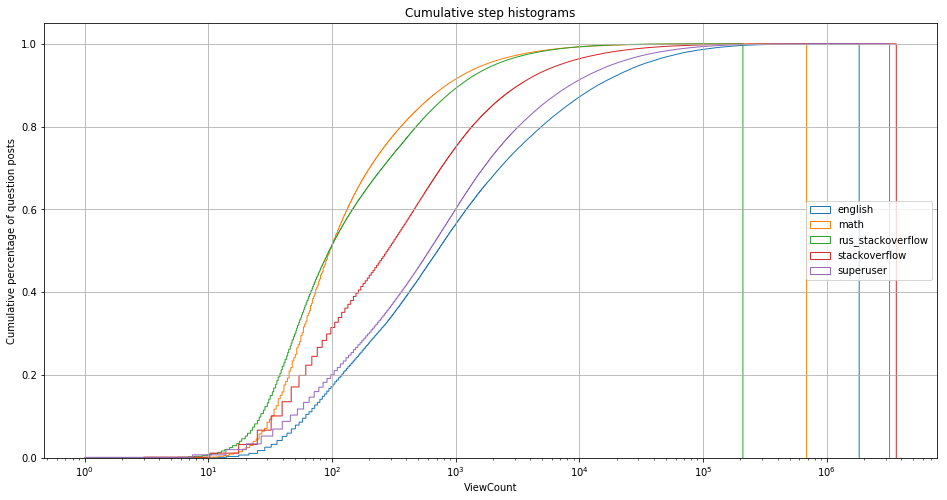

CPU times: user 3.38 s, sys: 497 ms, total: 3.88 s
Wall time: 9.18 s


In [22]:
%%time

## create plot data for cumulative viewcount
plot_data = {}
for i in data_array:
    plot_data[i] = datasets[i].select("viewcount").rdd.flatMap(lambda x: x).collect()
    #plot_data[i] = [x for x in plot_data[i] if x is not None] don't need this just yet

## plot cumulative distribution of viewcount across fora
n_bins = 500000
fig, ax = plt.subplots(figsize=(16, 8))
for i in data_array: # must change to data array later
    n, bins, patches = ax.hist(plot_data[i], n_bins, density=True, histtype='step',
                               cumulative=True, label=i)
ax.grid(True)
ax.set_xscale('log')
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('ViewCount')
ax.set_ylabel('Cumulative percentage of question posts')
plt.show()

### NB TO DO: Find threshold to delete low views to make sure users that can vote have seen the question

In [23]:
vc_thresh_data = {}

In [24]:
%%time

## finding means of viewcounts across fora

for i in data_array:
    vc_thresh_data[i] = datasets[i].select("viewcount").rdd.flatMap(lambda x: x).mean()

CPU times: user 37.2 ms, sys: 11.8 ms, total: 49 ms
Wall time: 17.3 s


In [25]:
vc_thresh_data

{'english': 7417.23764873184,
 'math': 544.8942256136423,
 'rus_stackoverflow': 563.8327930573985,
 'stackoverflow': 2290.244758630985,
 'superuser': 4695.632326063503}

# Define response variable

In [26]:
%%time

## create response variable normalised by views

for i in data_array:
    datasets[i] = datasets[i].withColumn('y_ravi', datasets[i]['score']/datasets[i]['viewcount'])
    print("\nThe average value of " +'\033[1m'+ i +'\033[0m'+ " y_ravi is " + 
          str(round(datasets[i].select("y_ravi").rdd.flatMap(lambda x: x).mean(),7)) + "\n")


The average value of english y_ravi is 0.0037778


The average value of math y_ravi is 0.0121854


The average value of rus_stackoverflow y_ravi is 0.006857


The average value of stackoverflow y_ravi is 0.002148


The average value of superuser y_ravi is 0.0027184

CPU times: user 46.2 ms, sys: 16.4 ms, total: 62.7 ms
Wall time: 15.6 s


In [27]:
%%time 

## content of "best" and "worst" questions based on Score/ViewCount

best_worst_qs = {}

for i in data_array:
    best_worst_qs[i] = pd.concat(
        [
            datasets[i].where(datasets[i].y_ravi == datasets[i].select('y_ravi').
                           rdd.flatMap(lambda x: x).max()).toPandas(),
            datasets[i].where(datasets[i].y_ravi == datasets[i].select('y_ravi').
                           rdd.flatMap(lambda x: x).min()).toPandas()
        ]
        , axis=0)

CPU times: user 130 ms, sys: 38.6 ms, total: 169 ms
Wall time: 28.8 s


In [28]:
best_worst_qs['math']

,body,title,viewcount,score,clean_body,y_ravi
0,<p>I am studying about ranked set sampling fro...,How to derive the distribution of mean estimat...,5,2,I am studying about ranked set sampling from ...,0.400000
0,<p>what is the answer of this indefinite integ...,Integral of exponential matrix,26,-8,what is the answer of this indefinite integra...,-0.307692
1,"<p><a href=""https://i.stack.imgur.com/CYzoG.jp...",Finding locus of a point,13,-4,I tried solving this and getting intersectio...,-0.307692


### export to latex

# Validation

In [29]:
%%time

## good/bad threshold validation

## choose thresholds
threshes = np.linspace(0.05, 0.95, num=37)

## create empty list for results
result = []

## create user-defined function to add threshold columns
def thresh_cols(a, high_threshold, low_threshold):
    '''function to add threshold columns'''        
    if a > high_threshold:
        return 'good'
    elif a <= low_threshold:
        return 'bad'

thresh_cols_udf = udf(thresh_cols, StringType())
   
for i in range(len(threshes)):
    ## store thresholds, lowest represents % good questions
    lo_thresh = np.quantile(datasets['english'].select('y_ravi').
                            rdd.flatMap(lambda x: x).collect(), threshes[i])
    hi_thresh = np.quantile(datasets['english'].select('y_ravi').
                            rdd.flatMap(lambda x: x).collect(), threshes[len(threshes)-i-1])
    
    # if statement to change over at 50% threshold
    if (i > (len(threshes) - 1) / 2):
        ## label questions according to high and low thresholds AFTER 50% THRESHOLD
        # here we only need one threshold
        datasets['english'] = datasets['english'].withColumn("col." + str(round(threshes[i], 3)),
                                                             thresh_cols_udf('y_ravi', lit(hi_thresh), lit(hi_thresh)))
    else:
        ## label questions according to high and low thresholds BEFORE 50% THRESHOLD
        # here there are two mirrored threshold, where NAs fill the middle
        datasets['english'] = datasets['english'].withColumn("col." + str(round(threshes[i], 3)),
                                                             thresh_cols_udf('y_ravi', lit(hi_thresh), lit(lo_thresh)))

'''
## get tokens and remove whitespace that messes up French and Linguistics
    toks_one <- tokens_remove(tokens(paste0(
      sxdf_q[sxdf_q[[as.character(threshes[i])]]=="good",][["Body"[1]]], collapse = " ")), 
                              "\\p{Z}", valuetype = "regex")
    toks_two <- tokens_remove(tokens(paste0(
      sxdf_q[sxdf_q[[as.character(threshes[i])]]=="bad",][["Body"[1]]], collapse = " ")), 
                              "\\p{Z}", valuetype = "regex")
    ## reassign docnames
    docnames(toks_one) <- "good"
    docnames(toks_two) <- "bad"
    
    ## we normalise the dfm by stemming, removing stopwords/punctuation and weighting proportionally
    docfm <- dfm_weight(dfm(c(toks_one, toks_two),
                            stem = TRUE, remove_punct = TRUE, remove = stopwords("english")),
                        "prop")
    
    ## bind results
    result <- rbind(result, c(threshes[i], 
                              textstat_dist(docfm, method="euclidean"), 
                              textstat_simil(docfm, method="cosine"), 
                              textstat_simil(docfm, method="jaccard"), 
                              datasets[k]))
'''

CPU times: user 1.15 s, sys: 250 ms, total: 1.4 s
Wall time: 29.4 s


In [36]:
show(datasets['english'], 30)

,body,title,viewcount,score,clean_body,y_ravi,col.0.05,col.0.075,col.0.1,col.0.125,...,col.0.725,col.0.75,col.0.775,col.0.8,col.0.825,col.0.85,col.0.875,col.0.9,col.0.925,col.0.95
0,<p>How do I know when to use <em>lay</em> and ...,"What is the difference between ""lay"" and ""lie""?",18413,35,How do I know when to use lay and when to u...,0.001901,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
1,<p>When you want to connect two closely relate...,Should I use a semicolon or a dash to connect ...,106724,52,When you want to connect two closely related ...,0.000487,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
2,<blockquote>\n <p><strong>Possible Duplicate:...,"What does Maugham mean by ""his spaghetti were""?",1131,11,Possible Duplicate: Was the usage &...,0.009726,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
3,<p>How do you say it correctly?</p>\n\n<ul>\n<...,"""Adult and children stories"" or ""Adults and ch...",959,2,How do you say it correctly? Adult and c...,0.002086,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
4,"<p>""Proven"" and ""proved"" both seem to mean the...","What is the difference between ""proven"" and ""p...",52711,50,"""Proven"" and ""proved"" both seem to mean the s...",0.000949,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
5,"<p>When reading to an audience, or speaking in...",When is it appropriate to use the original pro...,7708,17,"When reading to an audience, or speaking in c...",0.002206,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
6,<ol>\n<li>Are there rules of thumb for pinpoin...,Identifying British accents,5397,12,Are there rules of thumb for pinpointing Br...,0.002223,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
7,"<p>If I have two tasks, called ""Design"" and ""D...","In a project, what is the relationship between...",1921,3,"If I have two tasks, called ""Design"" and ""Dev...",0.001562,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
8,"<p>I understand that any term, grammatical or ...","Is ""facebook"" as a verb different from ""google...",2759,3,"I understand that any term, grammatical or no...",0.001087,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good
9,<blockquote>\n <p>He did <strong>nothing*</st...,About question tags,1804,6,He did nothing* . Which is the corr...,0.003326,None,None,None,None,...,good,good,good,good,good,good,good,good,good,good


# Modeling

In [76]:
## garbage collector to speed up computation
import gc
collected = gc.collect()
print("Garbage collector: collected %d objects." % collected)

Garbage collector: collected 875 objects.


In [47]:
## import elements from natural language toolkit
import nltk
#nltk.download('all') # uncomment after first run as admin check
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

In [54]:
def get_tokens(line):
    '''
    Function to parse text features
    '''
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

In [74]:
%%time

## tokenise and lemmatise using nltk function from import step
body_rdd = {}
for i in data_array:
    body_rdd[i] = datasets[i].select('clean_body').rdd.flatMap(lambda r: r).map(lambda line: (1, get_tokens(line)))

CPU times: user 8.7 ms, sys: 3.84 ms, total: 12.5 ms
Wall time: 626 ms


In [75]:
%%time

## look at first 10 terms from first post in english
print(body_rdd['english'].take(1)[0][1][:10])

['know', 'use', 'lay', 'use', 'lie', 'different', 'form', 'verb', 'always', 'getting']
CPU times: user 19.9 ms, sys: 4.17 ms, total: 24.1 ms
Wall time: 5.71 s


In [ ]:
%%time
print(datetime.now().time())

'''RUN LATER'''

# get rid of stop words
doc_stopwords = {}
for i in data_array:
    doc_stopwords[i] = body_rdd[i].flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
    # here we assume that words that appear very frequently are stop words
    doc_stopwords[i] = doc_stopwords[i].filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()
    '''3000 threshold needs attention!'''
    # remove stopwords and single letters
    body_rdd[i] = body_rdd[i].map(lambda r: (r[0],[w for w in r[1] if not w in doc_stopwords[i] and not len(w)==1]))

In [78]:
%%time

from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

## convert tokens into sparse vectors
body_df = {}
for i in data_array:
    body_df[i] = spark.createDataFrame(body_rdd[i], ["dummy","words"])
    body_df[i].cache()

In [79]:
## garbage collector to speed up computation
import gc
collected = gc.collect()
print("Garbage collector: collected %d objects." % collected)

Garbage collector: collected 315 objects.


In [80]:
## check first english post vector
print(body_df['english'].take(1))

[Row(dummy=1, words=['know', 'use', 'lay', 'use', 'lie', 'different', 'form', 'verb', 'always', 'getting', 'confused'])]


In [84]:
%%time
print(datetime.now().time())
'''BOTTLENECK TIME'''

cntvcr = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cntvcr_models = {}
word_feat_list = {}
for i in ['english']:
    cntvcr_models[i] = cntvcr.fit(body_df[i])
    word_feat_list[i] = cntvcr_models[i].transform(body_df[i])
    word_feat_list[i].cache()

## show word vectors and feature counts for fora:
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    word_feat_list[i].show(10)

19:59:55.544534

------------------
 english 
------------------



Py4JJavaError: An error occurred while calling o3051.showString.
: org.apache.spark.SparkException: Job 211 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:932)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:930)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:78)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:930)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:2128)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2041)
	at org.apache.spark.SparkContext$$anonfun$stop$6.apply$mcV$sp(SparkContext.scala:1949)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1340)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1948)
	at org.apache.spark.SparkContext$$anonfun$2.apply$mcV$sp(SparkContext.scala:575)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:216)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1$$anonfun$apply$mcV$sp$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1945)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply$mcV$sp(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anonfun$runAll$1.apply(ShutdownHookManager.scala:188)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at org.apache.hadoop.util.ShutdownHookManager$1.run(ShutdownHookManager.java:54)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3383)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2544)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2758)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59140)
Traceback (most recent call last):
  File "/Users/brad/anaconda3/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/brad/anaconda3/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Users/brad/anaconda3/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/brad/anaconda3/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/opt/apache-spark/libexec/python/pyspark/accumulators.py", l

In [ ]:
# converting pyspark.ml vectors to pyspark.mllib vectors

from pyspark.mllib.linalg import Vectors
def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = {}
feature_vec_list = {}
for i in data_array:
    features[i] = word_feat_list[i].select("features")
    feature_vec_list[i] = features[i].rdd.map(lambda r: as_mllib_vector(r[0]))
    feature_vec_list[i].cache()

## print first pyspark.mllib vectors for fora:
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print(feature_vec_list[i].take(1))

In [ ]:
## look at the first 100 words of the vocabulary
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print ("Vocabulary from CountVectorizerModel is:\n")
    print(cntvcr_models[i].vocabulary[:100])
    print("\n---\n")

    M = len(cntvcr_models[i].vocabulary)
    print("Number of terms M = ", M)

### LDA Model

In [ ]:
from pyspark.ml.regression import pyspark.ml.clustering.LDA

In [ ]:
%%time
print(datetime.now().time())

## fit LDA models with k=10 topics
from pyspark.ml.clustering import LDA

lda = LDA(k=10, maxIter=5)

lda_model_list = {}
for i in data_array:
    lda_model_list[i] = lda.fit(word_feat_list[i])

In [ ]:
%%time
print(datetime.now().time())

# calculate the perplexity and likelihood for each forum's model

loglik_list = {}
logper_list = {}
for i in data_array:
    loglik_list[i] = lda_model_list[i].logLikelihood(word_feat_list[i])
    logper_list[i] = lda_model_list[i].logPerplexity(word_feat_list[i])
    print("Finished", i, "at", datetime.now().time())

# low perplexity value indicates the model predicts the sample well

for i in data_array:
    print("The lower bound on the log likelihood of the " +'\033[1m'+ i +'\033[0m'+ " corpus is: " + str(loglik_list[i]))
    print("The upper bound on the perplexity of the " +'\033[1m'+ i +'\033[0m'+ " corpus is: " + str(logper_list[i]))
    print('\n')

In [ ]:
%%time
print(datetime.now().time())

## first 5 words of the 10 topics from the LDA models per forum
topic_list = {}
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    topic_list[i] = lda_model_list[i].describeTopics(5)
    #print("The topics described by their top-weighted terms:\n")
    #topic_list[i].show(truncate=False)
    # show the results
    topic_j = topic_list[i].select("termIndices").rdd.map(lambda r: r[0]).collect()
    for j in topic_j:
        print(np.array(cntvcr_models[i].vocabulary)[j])
    print('\n')

# Convert notebook to python file

In [ ]:
!jupyter nbconvert --to script 1-initial-analysis.ipynb